In [1]:
# Cell 1: Nhập thư viện và tải dữ liệu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Thiết lập hiển thị cho Seaborn/Matplotlib
sns.set_theme(style="whitegrid")
%matplotlib inline 

# Tải dữ liệu (Thay đổi đường dẫn nếu file không nằm cùng thư mục)
df = pd.read_csv('creditcard.csv')

print("5 dòng dữ liệu đầu tiên:")
print(df.head())

print("\nThông tin về kiểu dữ liệu (kiểm tra giá trị null):")
# Public: Check for any missing values (should be 0)
print(df.info())

5 dòng dữ liệu đầu tiên:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

       

Số lượng giao dịch theo Class:
Class
0    284315
1       492
Name: count, dtype: int64

Tỷ lệ phần trăm giao dịch:
Hợp lệ (0): 99.8273%
Gian lận (1): 0.1727%


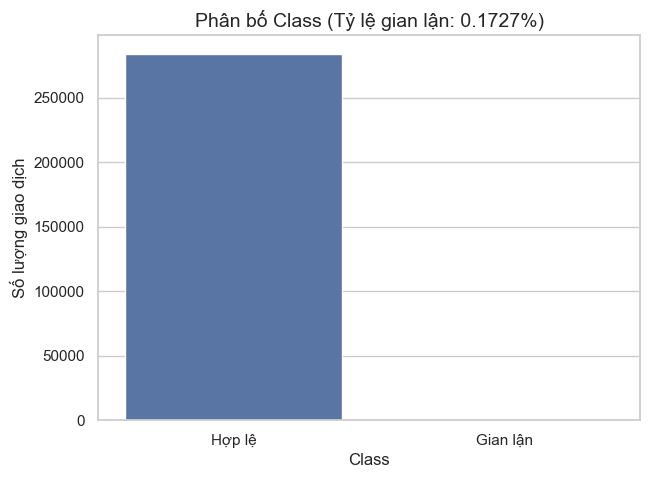

In [2]:
# Cell 2: Phân tích Mất Cân bằng

# 1. Đếm số lượng và tính tỷ lệ
class_counts = df['Class'].value_counts()

# Tính tỷ lệ phần trăm
fraud_rate = class_counts[1] / len(df) * 100

print("Số lượng giao dịch theo Class:")
print(class_counts)

print("\nTỷ lệ phần trăm giao dịch:")
print(f"Hợp lệ (0): {class_counts[0] / len(df) * 100:.4f}%")
print(f"Gian lận (1): {fraud_rate:.4f}%")

# 2. Vẽ biểu đồ trực quan hóa
plt.figure(figsize=(7, 5))
sns.countplot(x='Class', data=df)
plt.title(f'Phân bố Class (Tỷ lệ gian lận: {fraud_rate:.4f}%)', fontsize=14)
plt.ylabel('Số lượng giao dịch')
plt.xticks([0, 1], ['Hợp lệ', 'Gian lận'])
plt.show()

In [3]:
# Cell 3: Chuẩn hóa dữ liệu

# 1. Khởi tạo RobustScaler: Thường được ưu tiên hơn StandardScaler vì nó ít bị ảnh hưởng bởi các giá trị ngoại lai (outliers)
rob_scaler = RobustScaler()

# 2. Chuẩn hóa và tạo cột mới
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 3. Xóa các cột gốc 'Time' và 'Amount'
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 4. Sắp xếp lại cột để nhìn trực quan hơn
scaled_features = ['scaled_amount', 'scaled_time'] + [col for col in df.columns if col not in ['Class', 'scaled_amount', 'scaled_time']]
df = df[scaled_features + ['Class']]

print("5 dòng dữ liệu đầu tiên sau khi chuẩn hóa:")
print(df.head())

5 dòng dữ liệu đầu tiên sau khi chuẩn hóa:
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25      

In [4]:
# Cell 4: Phân chia Dữ liệu (Train/Test Split)

# 1. Tách X (features) và y (target)
X = df.drop('Class', axis=1)
y = df['Class']

# 2. Phân chia dữ liệu (20% cho Test, 80% cho Train)
# stratify=y LÀ BẮT BUỘC: Giúp duy trì tỷ lệ 0.17% gian lận trong cả hai tập
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Kiểm tra lại tỷ lệ
print(f"Số lượng mẫu trong tập Train: {len(X_train)} ({y_train.sum()} gian lận)")
print(f"Số lượng mẫu trong tập Test: {len(X_test)} ({y_test.sum()} gian lận)")
print(f"Kiểm tra tỷ lệ Gian lận trong tập Test: {y_test.sum() / len(y_test) * 100:.4f}%")

Số lượng mẫu trong tập Train: 227845 (394 gian lận)
Số lượng mẫu trong tập Test: 56962 (98 gian lận)
Kiểm tra tỷ lệ Gian lận trong tập Test: 0.1720%


In [5]:
# Cell 5: Xây dựng và Đánh giá Mô hình Baseline

# 1. Huấn luyện Logistic Regression
# class_weight='balanced': Tự động gán trọng số cao hơn cho lớp thiểu số (gian lận)
lr = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)

# 2. Dự đoán trên tập Test
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1] 

print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH BASELINE (Logistic Regression) ---")

# 3. Phân tích chỉ số
# a. ROC AUC Score (khả năng phân biệt tổng quát)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# b. Classification Report (Chỉ số chi tiết: Recall và Precision)
print("\nClassification Report (Rất Quan Trọng):")
print(classification_report(y_test, y_pred))

# c. Confusion Matrix (Ma trận nhầm lẫn)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
# Hàng 0: Dự đoán Hợp lệ / Hàng 1: Dự đoán Gian lận
# Cột 0: Thực tế Hợp lệ / Cột 1: Thực tế Gian lận
print(cm)

# Giải thích Confusion Matrix (Ví dụ: Chú ý góc trên phải và dưới trái)
TN = cm[0][0] # True Negative: Đúng là Hợp lệ
FP = cm[0][1] # False Positive: Báo Gian lận NHƯNG thực tế là Hợp lệ (Cảnh báo sai)
FN = cm[1][0] # False Negative: Báo Hợp lệ NHƯNG thực tế là Gian lận (Bỏ sót gian lận)
TP = cm[1][1] # True Positive: Đúng là Gian lận
print(f"\n=> Báo cáo: Mô hình đã bỏ sót {FN} giao dịch Gian lận (False Negative).")


--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH BASELINE (Logistic Regression) ---
ROC AUC Score: 0.9721

Classification Report (Rất Quan Trọng):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962


Confusion Matrix:
[[55478  1386]
 [    8    90]]

=> Báo cáo: Mô hình đã bỏ sót 8 giao dịch Gian lận (False Negative).
